In [1]:
import pickle
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Custom library
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import mode

In [2]:
# Load training and validation datasets
train_pd, val_pd, test_pd = {}, {}, {}
train_pd['rock'] = pd.read_csv('datasets/raw/rock_train.csv')
train_pd['paper'] = pd.read_csv('datasets/raw/paper_train.csv')
train_pd['scissors'] = pd.read_csv('datasets/raw/scissors_train.csv')
val_pd['rock'] = pd.read_csv('datasets/raw/rock_val.csv')
val_pd['paper'] = pd.read_csv('datasets/raw/paper_val.csv')
val_pd['scissors'] = pd.read_csv('datasets/raw/scissors_val.csv')

train_pd['lizard'] = pd.read_csv('datasets/raw/lizard_train.csv')
train_pd['spock'] = pd.read_csv('datasets/raw/spock_train.csv')
val_pd['lizard'] = pd.read_csv('datasets/raw/lizard_val.csv')
val_pd['spock'] = pd.read_csv('datasets/raw/spock_val.csv')


# Load test datasets
## test_0.csv, test_1.csv, test_2.csv each includes a recording a single gesture.
## test_combined.csv includes a recording of changing gestures.
for i in range(3):
    test_pd[i] = pd.read_csv('datasets/raw/test_'+str(i)+'.csv')
# test_combined_pd = pd.read_csv('datasets/raw/test_combined.csv')
test_combined_pd = pd.read_csv('datasets/raw/test_combined.csv')

In [3]:
test_combined_pd.head()

,time,Thumb-0-x,Thumb-0-y,Thumb-0-z,Thumb-1-x,Thumb-1-y,Thumb-1-z,Thumb-2-x,Thumb-2-y,Thumb-2-z,...,Pinky-1-z,Pinky-2-x,Pinky-2-y,Pinky-2-z,Pinky-3-x,Pinky-3-y,Pinky-3-z,Pinky-4-x,Pinky-4-y,Pinky-4-z
0,1.641526e+15,7.689978,137.894577,67.749779,7.689978,137.894577,67.749779,-27.678133,143.974411,43.476521,...,-3.073007,27.341282,158.074112,-33.160255,23.743763,156.252502,-49.650059,20.353157,153.964600,-64.040390
1,1.641526e+15,7.673332,137.869324,67.735344,7.673332,137.869324,67.735344,-27.702175,143.950027,43.473080,...,-3.082253,27.320917,158.049591,-33.169575,23.728226,156.212723,-49.658741,20.342329,153.912476,-64.048210
2,1.641526e+15,7.663088,137.849045,67.718674,7.663088,137.849045,67.718674,-27.723974,143.924835,43.472034,...,-3.095908,27.301003,158.033249,-33.183208,23.713415,156.187698,-49.672516,20.333183,153.883179,-64.062630
3,1.641526e+15,7.657822,137.832291,67.704529,7.657822,137.832291,67.704529,-27.740520,143.903091,43.473110,...,-3.108594,27.287230,158.002594,-33.195496,23.704235,156.137009,-49.683544,20.328428,153.815643,-64.071991
4,1.641526e+15,7.651985,137.815414,67.690575,7.651985,137.815414,67.690575,-27.757704,143.883469,43.475052,...,-3.121253,27.270449,157.986938,-33.208443,23.694042,156.113068,-49.696983,20.325392,153.788406,-64.086578


In [4]:
# Parameters

# LABELS = ['rock', 'paper', 'scissors', 'lizard', 'spock']

LABELS = ['rock', 'paper', 'scissors']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
dim_names = 'xyz'
joint_names = []
for f in range(5):
    for b in range(5):
        for d in range(3):
            joint_name = finger_names[f]+'-'+str(b)+'-'+dim_names[d]
            joint_names.append(joint_name)

In [5]:
# Functions for processing datasets
def shift_origin(data_pd):
    """
    Shift coordinates of all joints with respect to the joint Thumb-0.
    Inputs:
        - data_pd: DataFrame. 
    Outputs:
        - shifted_data_pd: DataFrame with coordinate data shifted.        
    """
    #######################################
    ########### To Be Done Here ###########
    shifted_data_pd = data_pd.copy()
    
    # Identify Thumb-0 coordinate columns for each row
    thumb_0_x = data_pd['Thumb-0-x']
    thumb_0_y = data_pd['Thumb-0-y']
    thumb_0_z = data_pd['Thumb-0-z']
    
    for col in data_pd.columns:
        if '-x' in col:
            shifted_data_pd[col] = shifted_data_pd[col] - thumb_0_x
        elif '-y' in col:
            shifted_data_pd[col] = shifted_data_pd[col] - thumb_0_y
        elif '-z' in col:
            shifted_data_pd[col] = shifted_data_pd[col] - thumb_0_z
        
    #######################################
    return shifted_data_pd

def cut_head_tail(data_pd, head_len=500, data_len=6000):
    """
    Cut the head and tail of recorded data for sanity.
    Inputs:
        - data_pd: DataFrame.
        - head_len: the length of head dropped.
        - data_len: the length of the kept data.
    Outputs:
        - cut_data_pd: 
            None, if the length including head_len and data_len exceeds the length of data_pd;
            otherwise, DataFrame with head cut and the length of data_len.
    """
    
    #######################################
    ########### To Be Done Here ###########
    if head_len + data_len > len(data_pd):
        cut_data_pd = data_pd
    else:
        cut_data_pd = data_pd[head_len:head_len+data_len]
    #######################################
    return cut_data_pd

def concat_different_labels(data_pd_dict):
    """
    Form a unified DataFrame with all labels included.
    Inputs:
        - data_pd_dict: Dictionary
            - ['rock']: DataFrame with rock label.
            - ['paper']: DataFrame with paper label.
            - ['scissors']: DataFrame with scissors label.
    Outputs:
        - concatenated_data_pd: DataFrame with all labels included.
    """
    # return pd.concat([data_pd_dict['rock'], data_pd_dict['paper'], data_pd_dict['scissors'], data_pd_dict['lizard'],data_pd_dict['spock']])
    return pd.concat([data_pd_dict['rock'], data_pd_dict['paper'], data_pd_dict['scissors']])
    
def split_features_label(data_pd):
    """
    Split DataFrame into features (X) and label (y).
    Inputs:
        - data_pd: DataFrame.
    Outputs:
        - X: feature data. numpy array with shape (num_samples, num_features), where num_features should be 69.
        - y: label data. numpy array with shape (num_samples,).
    """
    #######################################
    ########### To Be Done Here ###########
    if 'label' in data_pd.columns:
        y = data_pd['label'].values
        X = data_pd.drop(columns=['label', 'time', 'Thumb-0-x', 'Thumb-0-y', 'Thumb-0-z', 'Thumb-1-x', 'Thumb-1-y', 'Thumb-1-z']).values
    else:
        y = None
        X = data_pd.drop(columns=['time', 'Thumb-0-x', 'Thumb-0-y', 'Thumb-0-z', 'Thumb-1-x', 'Thumb-1-y', 'Thumb-1-z']).values
    #######################################
    return X, y

In [6]:
# Process datasets
processed_train_pd = {}
processed_val_pd = {}
processed_test_pd = {}
for label in LABELS:
    processed_train_pd[label] = cut_head_tail(train_pd[label], head_len=500, data_len=6000)
    processed_train_pd[label] = shift_origin(processed_train_pd[label])
    processed_train_pd[label]['label'] = label
    processed_val_pd[label] = cut_head_tail(val_pd[label], head_len=100, data_len=1500)
    processed_val_pd[label] = shift_origin(processed_val_pd[label])
    processed_val_pd[label]['label'] = label
    
train_data = concat_different_labels(processed_train_pd)
X_train, y_train = split_features_label(train_data)
val_data = concat_different_labels(processed_val_pd)
X_val, y_val = split_features_label(val_data)

X_test = {}
for i in range(3):
    processed_test_pd[i] = cut_head_tail(test_pd[i], head_len=100, data_len=1500)
    processed_test_pd[i] = shift_origin(processed_test_pd[i])
    X_test[i], _ = split_features_label(processed_test_pd[i])

processed_test_combined_pd = shift_origin(test_combined_pd)
X_test_combined, _ = split_features_label(processed_test_combined_pd)

In [7]:
def train_validate_model(X_train, y_train, X_val, y_val):
    """
    Train and validate a logistic regression model for hand gesture classifier.
    Inputs:
        - X_train: feature data of training dataset. numpy array with shape (num_train_samples, num_features).
        - y_train: label data of training dataset. numpy array with shape (num_train_samples,).
        - X_val: feature data of validation dataset. numpy array with shape (num_val_samples, num_features).
        - y_val: label data of validation dataset. numpy array with shape (num_val_samples,).
    Outputs:
        - model: logistic regression model.
        - train_accuracy
        - val_accuracy
    """
    #######################################
    ########### To Be Done Here ###########
    # Logistic regression model
    model = LogisticRegression(max_iter=10000)
    
    # Encode the string labels to integers
    label_mapping = {
        'rock': 0,
        'paper': 1,
        'scissors': 2,
        'lizard' : 3,
        'spock' : 4
    }
    y_train_encoded = np.array([label_mapping[label] for label in y_train])
    y_val_encoded = np.array([label_mapping[label] for label in y_val])
    
    # Fit the model
    model.fit(X_train, y_train_encoded)
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
    #######################################
    return model, train_accuracy, val_accuracy


In [8]:
model, train_accuracy, val_accuracy = train_validate_model(X_train, y_train, X_val, y_val)
print('Training accuracy: {0:.2f}%'.format(100 * train_accuracy))
print('Validation accuracy: {0:.2f}%'.format(100 * val_accuracy))

Training accuracy: 100.00%
Validation accuracy: 97.84%


In [25]:
def single_hand_gesture_recognition(model, X_test_single, LABELS):
    """
    Train and validate a logistic regression model for hand gesture classifier.
    Inputs:
        - model: logistic regression model
        - X_test_single: feature data of test dataset with a single ground truth label. \
            numpy array with shape (num_test_samples, num_features).
        - LABELS: ['rock', 'paper', 'scissors']
    Outputs:
        - hand_gesture: string. 'rock', 'paper', or 'scissors'.
    """
    #######################################
    ########### To Be Done Here ###########
    # Predict using the trained model
    predicted_labels_encoded = model.predict(X_test_single)
    
    # Determine the most common predicted label
    result = mode(predicted_labels_encoded)
    if np.isscalar(result.mode):
        most_common_label_encoded = result.mode
    else:
        most_common_label_encoded = mode(predicted_labels_encoded).mode[0]

    # Encode the string labels to integers
    label_mapping = {
        'rock': 0,
        'paper': 1,
        'scissors': 2,
        'lizard' : 3,
        'spock' : 4
    }
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    hand_gesture = reverse_label_mapping[most_common_label_encoded]
    
#     print(predicted_labels_encoded)
    
    #######################################
    return hand_gesture

def offline_hand_gesture_classifer_and_visualizer(model, X_test_combined, LABELS, label_colors):
    """
    Classify the hand gesture at each time step and visualize the probability distribution over potential \
    hand gestures at each time step.
    Inputs:
        - model: logistic regression model
        - X_test_combined: time series feature data of test dataset with changing hand gesture labels. \
            numpy array with shape (num_test_combined_samples, num_features).
        - LABELS: ['rock', 'paper', 'scissors']
        - label_colors:
            -['rock']: 'r'
            -['paper']: 'y'
            -['scissors']: 'b'
    Outputs:
        - Plot the probability distribution over potential hand gestures at each time step.
    """
    fig, ax = plt.subplots()
    #######################################
    ########### To Be Done Here ###########
    # Get probability estimates
    probabilities = model.predict_proba(X_test_combined)

    # Extract the probabilities for each label
    rock_probs = probabilities[:, 0]
    paper_probs = probabilities[:, 1]
    scissors_probs = probabilities[:, 2]
    # lizard_probs = probabilities[:, 3]
    # spock_probs = probabilities[:, 4]

    # Rolling windows
    time = 150
    for i in range(probabilities.shape[0]-time):
        rock_probs[i] = np.mean(probabilities[i:i+time,0])
        paper_probs[i] = np.mean(probabilities[i:i+time,1])
        scissors_probs[i] = np.mean(probabilities[i:i+time,2])
    
    # Plot probabilities for each label
    ax.plot(rock_probs, color=label_colors['rock'], label='rock')
    ax.plot(paper_probs, color=label_colors['paper'], label='paper')
    ax.plot(scissors_probs, color=label_colors['scissors'], label='scissors')
    # ax.plot(lizard_probs, color='g', label='lizard')
    # ax.plot(spock_probs, color='pink', label='spock')
    
    ax.set_xlabel('Time step')
    ax.set_ylabel('Probability')
    ax.set_title('Probability Distribution Over Hand Gestures at Each Time Step')
    #######################################
    ax.legend()
    plt.show()
    return

In [26]:
for i in range(3):
    X_test_single = X_test[i]
    hand_gesture = single_hand_gesture_recognition(model, X_test_single[0].reshape(1, -1), LABELS)
    print("The hand gesture in test_"+str(i)+".csv is "+hand_gesture+".")

The hand gesture in test_0.csv is paper.
The hand gesture in test_1.csv is scissors.
The hand gesture in test_2.csv is rock.


/tmp/ipykernel_31458/3332987053.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  result = mode(predicted_labels_encoded)
/tmp/ipykernel_31458/3332987053.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label_encoded = mode(predicted_labels_enco

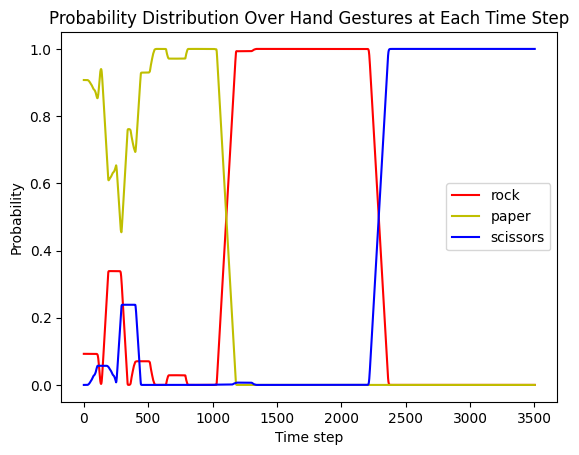

In [27]:
label_colors = {'rock': 'r', 'paper': 'y', 'scissors': 'b'}
offline_hand_gesture_classifer_and_visualizer(model, X_test_combined, LABELS, label_colors)

In [28]:
# Save the trained model.
model_folder = 'models'
filename = 'original_game.pkl'
with open(join(model_folder, filename), 'wb') as f:
    pickle.dump(model, f)
    print(join(model_folder, filename)+" is saved.")

models/original_game.pkl is saved.
